# GitHub repositories analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

## Read the data

In [2]:
files = glob.glob("./data/**/*.csv", recursive=True)
print("Encontrados", len(files), "ficheros")

Encontrados 84 ficheros


In [3]:
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [4]:
df["date"] = pd.to_datetime(df["ts"], format='%Y-%m-%d')

In [5]:
ts_max = df["ts"].unique().max()
today = df[df.ts==ts_max]
head_total = 5 if today.ts.count()>5 else today.ts.count()

In [6]:
columns=["name","views_total","views_uniques","clones_total"]
today[columns].sort_values(by=["views_total","views_uniques"], ascending=False).head(head_total)

,name,views_total,views_uniques,clones_total
29,kotlin-ktor,3,1,0
28,istio-wasm-filter-golang,2,1,0
30,ml-github,1,1,0
27,golang-rest-api-cassandra,0,0,1
31,ta,0,0,40


In [7]:
repos = df.name.unique().tolist()

In [8]:
dict_df_repos = dict()
for repo_name in repos:
    dict_df_repos[repo_name] = df[df.name==repo_name]

## Data analysis

In [9]:
df_grouped = df.groupby(['name']).agg({"date": ["min"], "stars_count": ["max"],"clones_uniques": ["sum"],"views_total": ["sum", "max"]})

### Views

In [10]:
views_best_quantile = 0.75
views_worst_quantile = 0.25
best_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_best_quantile)
worst_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_worst_quantile)
print("Best views over:", best_views_percentile)
print("Worst views under:", worst_views_percentile)

Best views over: 30.5
Worst views under: 0.0


In [11]:
views=df_grouped[('views_total')]
views_best = views[views['sum'] > best_views_percentile]
views_best.sort_values(by='sum', ascending=False)

,sum,max
name,,
kotlin-ktor,438,49
kustomize-vs-helm,317,138
quarkus-kotlin-example,299,46
ocp-monitoring-golang,212,133
ml-github,168,41
golang-rest-api-cassandra,149,27
b0rr3g0-blog,135,48
mqtt-golang-influxdb,90,25
golang-k8s-helm-helloworld,83,42


#### Best views repositories

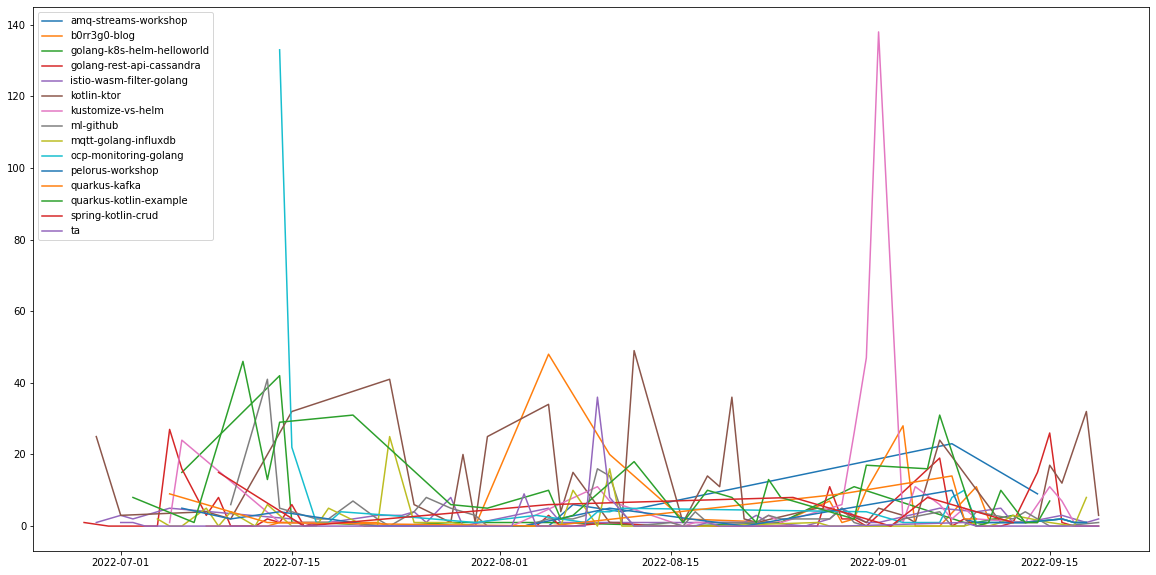

In [12]:
plt.figure(figsize=(20,10))
for repo_name in views_best.index.tolist():
    df_r = dict_df_repos[repo_name].sort_values(by="date")
    x = df_r.date
    y = df_r.views_total
    plt.plot(x, y, label=repo_name)
    
plt.legend(loc = "upper left")

#### Sum views total

In [13]:
df_total_views=df.groupby(['date']).agg({"views_total": ["sum"]}).sort_values(by="date", ascending=True)

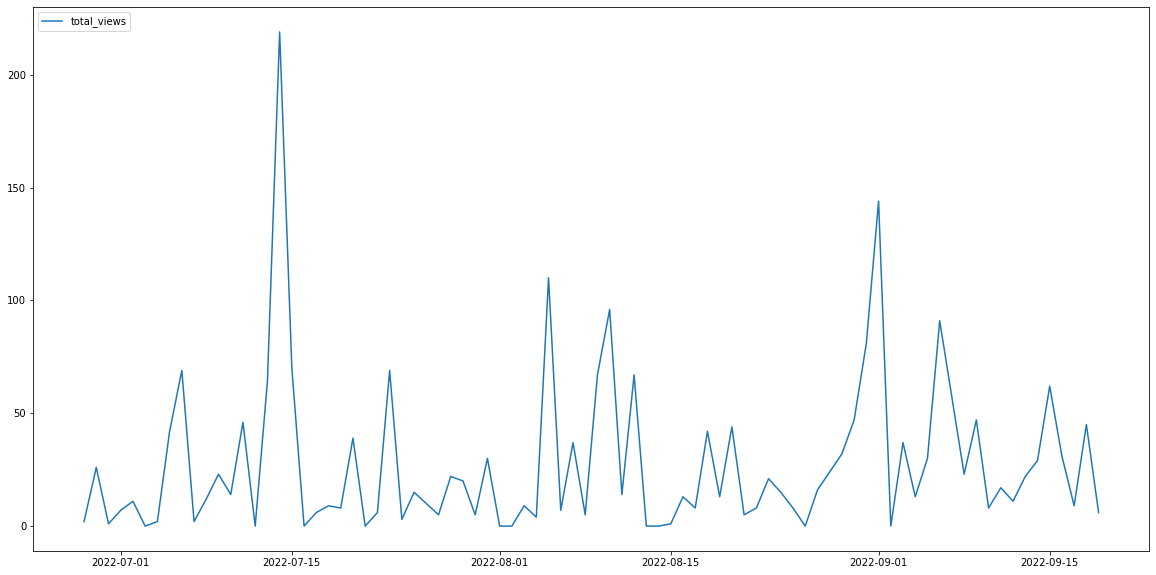

In [14]:
plt.figure(figsize=(20,10))
x = df_total_views.index
y = df_total_views[('views_total', 'sum')]
plt.plot(x, y, label="total_views")
plt.legend(loc = "upper left")

### Clones

In [15]:
# calculate the best 25% repositories
best_clones_quantile = 0.75
worst_clones_quantile = 0.25
best_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(best_clones_quantile)
worst_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(worst_clones_quantile)
print("Best clones over:", best_clones_percentile)
print("Worst clones under:", worst_clones_percentile)

Best clones over: 3.0
Worst clones under: 1.0


In [16]:
clones=df_grouped[('clones_uniques')]
clones_best = clones[clones['sum'] > best_clones_percentile]
clones_best.sort_values(by='sum', ascending=False)

,sum
name,
golang-rest-api-cassandra,1265
ta,1176
iot-devices-crud,675
mqtt-golang-influxdb,514
ml-github,122
b0rr3g0-blog,31
kustomize-vs-helm,13
ocp-HTPasswd-file-provider,10
ocp-monitoring-golang,10


# Stars

In [17]:
# calculate the best 50% repositories
best_stars_quantile = 0.75
worst_stars_quantile = 0.25
best_stars_percentile = df_grouped[('stars_count', 'max')].quantile(best_stars_quantile)
worst_stars_percentile = df_grouped[('stars_count', 'max')].quantile(worst_stars_quantile)
print("Best stars over:", best_stars_percentile)
print("Worst stars under:", worst_stars_percentile)

Best stars over: 1.0
Worst stars under: 0.0


In [18]:
stars=df_grouped[('stars_count')]
stars_best = stars[stars['max'] > best_stars_percentile]
stars_best.sort_values(by=['max'], ascending=False)

,max
name,
mqtt-golang-influxdb,12
kotlin-ktor,6
spring-kotlin-crud,6
kops-aws,4
kustomize-vs-helm,4
jenkins-ci,3
ta,3
golang-k8s-helm-helloworld,2
golang-rest-api-cassandra,2


# Red zone

In [19]:
repos = pd.read_csv("./repos.csv")

# remove colum
repos = repos.iloc[:,1:]
# remove owner
#repos = repos.drop(labels="owner",axis=1)
# add num topics
#repos["num_topics"] = len(repos.topics.str.split(','))
def count_topics(topics):
    return 0 if topics.count(',') == 0 else topics.count(',')+1
repos["topics_count"] = repos.apply(lambda row : count_topics(row.topics), axis=1)
# remove topics
repos = repos.drop(labels="topics",axis=1)
# format date
repos["latest_commit_date"] = pd.to_datetime(repos["latest_commit_date"], format='%Y%m%d')
# days until latest commit
today = pd.to_datetime('today')
repos["days_latest_commit"] = (today - repos.latest_commit_date).dt.days
# views
def views_total(name):
    try:
        return df_grouped.loc[name]['views_total']['sum']
    except Exception as e:
        print("[Views] Error ", name, " ==> ", e)
        return 0
repos["views_total"] = repos.apply(lambda row: views_total(row["name"]), axis=1)

#stars
def stars(name):
    try:
        return df_grouped.loc[name][('stars_count')]
    except Exception as e:
        print("[Stars] Error ", name, " ==> ", e)
        return 0
repos["stars_total"] = repos.apply(lambda row: stars(row["name"]), axis=1)

# clones
def clones(name):
    try:
        return df_grouped.loc[name]['clones_uniques']['sum']
    except Exception as e:
        print("[Clones] Error ", name, " ==> ", e)
        return 0
repos["clones_total"] = repos.apply(lambda row: clones(row["name"]), axis=1)

[Views] Error  beautifulhugo  ==>  'beautifulhugo'
[Views] Error  blog  ==>  'blog'
[Views] Error  clover  ==>  'clover'
[Views] Error  git-changelog-maven-plugin  ==>  'git-changelog-maven-plugin'
[Views] Error  github-traffic  ==>  'github-traffic'
[Views] Error  hugo-PaperMod  ==>  'hugo-PaperMod'
[Views] Error  icepie  ==>  'icepie'
[Views] Error  istio  ==>  'istio'
[Views] Error  kubernetes-golang-operator  ==>  'kubernetes-golang-operator'
[Views] Error  petclinic-config  ==>  'petclinic-config'
[Views] Error  spring-boot-elk  ==>  'spring-boot-elk'
[Views] Error  spring-cloud-ms2  ==>  'spring-cloud-ms2'
[Views] Error  spring-data-mongodb  ==>  'spring-data-mongodb'
[Views] Error  terraform-aws-demo  ==>  'terraform-aws-demo'
[Views] Error  vagrant-php-boxes  ==>  'vagrant-php-boxes'
[Stars] Error  beautifulhugo  ==>  'beautifulhugo'
[Stars] Error  blog  ==>  'blog'
[Stars] Error  clover  ==>  'clover'
[Stars] Error  git-changelog-maven-plugin  ==>  'git-changelog-maven-plugin'

In [20]:
len(repos)

72

In [21]:
# Scores by labels
cut_labels = ['S', 'A', 'B', 'C']
# FIXME ver si es mejor 1 mes, 6 meses 2 años por ejemplo
cut_bins = [0, 
            365/2, # 6 meses
            365, # 1 año
            365*3, # 3 años
            365*99]
repos['score_commits'] = pd.cut(repos['days_latest_commit'], bins=cut_bins, labels=cut_labels, include_lowest=True)

# Topics value
cut_labels = [False, True]
cut_bins = [-1, 0, 99999]
repos['score_topics'] = pd.cut(repos['topics_count'], bins=cut_bins, labels=cut_labels)

# Views score
cut_labels = ['C', 'B', 'A', 'S']
# rank for zero values
repos['views_total'] = repos['views_total'].rank(method='min')
cut_bins = [0, 
            repos['views_total'].quantile(q=0.25),
            repos['views_total'].quantile(q=0.75),
            repos['views_total'].quantile(q=0.9),
            repos['views_total'].quantile(q=1)]
repos['score_views'] = pd.cut(repos['views_total'], bins=cut_bins, labels=cut_labels)

# Clones score
cut_labels = ['C', 'B', 'A', 'S']
repos['clones_total'] = repos['clones_total'].rank(method='min')
cut_bins = [0, 
            repos['clones_total'].quantile(q=0.25),
            repos['clones_total'].quantile(q=0.75),
            repos['clones_total'].quantile(q=0.9),
            repos['clones_total'].quantile(q=1)]
repos['score_clones'] = pd.cut(repos['clones_total'], bins=cut_bins, labels=cut_labels)

# stars
# FIXME this structure have to change because depends of the user
cut_labels = ['C', 'B', 'A', 'S']
cut_bins = [0, 1, 5, 10, 99]
repos['score_stars'] = pd.cut(repos['stars_total'], bins=cut_bins, labels=cut_labels, include_lowest=True)

In [22]:
weights = { 
    'score_commits': {
        'weight': 40,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 25,
                   'C': 0 } 
    },
    'score_topics': {
        'weight': 10,
        'labels': {True: 100,
                   False: 0}
    },
    'score_views':  {
        'weight': 25,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 30,
                   'C': 0 }
    },
    'score_stars':  {
        'weight': 15,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 40,
                   'C': 0 }
    },
    'score_clones':  {
        'weight': 10,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 40,
                   'C': 0 }
    }
}
def score(row):
    score = 0
    for k in weights.keys():
        score += (weights[k]['labels'][row[k]] * weights[k]['weight']/100)
    return score
        
repos["score_total"] = repos.apply(lambda row: score(row), axis=1)
repos = repos.sort_values(by=['score_total'], ascending = False)

In [23]:
table_columns = ['name', 'score_commits', 'score_topics', 'score_views', 'score_stars', 'score_clones', 'score_total']
table = repos[table_columns]
color_c = 'background-color: #c91e1e;'
color_b = 'background-color: #ffc258;'
color_a = 'background-color: #9bc2fd;'
color_s = 'background-color: #5e9400;'
style = table.style.set_table_styles([  
    {'selector': '.S', 'props': color_s},
    {'selector': '.A', 'props': color_a},
    {'selector': '.B', 'props': color_b},
    {'selector': '.C', 'props': color_c},
    {'selector': '.False', 'props': color_c},
    {'selector': '.True', 'props': color_s},
], overwrite=False)

cell_color = pd.DataFrame(table[table_columns],
                          index=repos.index)

style.set_td_classes(cell_color)
style.bar(subset=["score_total",], color='lightgreen')
style.format({'score_total': "{:20,.0f}"})

,name,score_commits,score_topics,score_views,score_stars,score_clones,score_total
39,kustomize-vs-helm,S,True,S,B,S,91
15,golang-rest-api-cassandra,S,True,S,B,S,91
3,b0rr3g0-blog,S,True,S,C,S,85
41,ml-github,S,True,S,C,S,85
63,ta,S,True,A,B,S,84
47,ocp-monitoring-golang,S,True,S,C,A,82
14,golang-k8s-helm-helloworld,S,True,A,B,A,80
34,kops-aws,S,True,A,B,B,78
23,iot-devices-crud,S,True,A,C,S,78
46,ocp-HTPasswd-file-provider,S,True,A,C,A,74


In [24]:
print('Puntuación media: ', sum(repos['score_total'])/len(repos))

Puntuación media:  29.694444444444443


In [25]:
df_red_zone = df_grouped[df_grouped[('stars_count', 'max')] <= worst_stars_percentile]
df_red_zone = df_red_zone[df_red_zone[('clones_uniques', 'sum')] <= worst_clones_percentile]
df_red_zone = df_red_zone[df_red_zone[('views_total', 'sum')] <= worst_views_percentile]
df_red_zone.index.values.tolist()

['kafka-gitops',
 'kubernetes-pipeline-plugin',
 'ms-config-server',
 'poc-k8s-ambassador',
 'terraform-ansible-aws',
 'tinygo-site']